<a href="https://colab.research.google.com/github/Saurabhgill9/Saurabh_Portfolio/blob/master/ASL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#American Sign Language detection 

In this notebook, we will go through the below steps to complete the ASL sign language detection 

1. Installing and importing libraries
2. Importing the data
3. Data pre-processing 
4. Working with MediaPipe framework 
5. Data preparation for ML model
6. Multi-label classification models
7. Results and discussion 




## 1. Installing and importing libraries

In [ ]:
!pip install mediapipe opencv-python
! pip install kaggle

  Using cached mediapipe-0.8.9-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (32.8 MB)


In [ ]:
# Importing required libraries 
import mediapipe as mp
import cv2
import numpy as np
import uuid
import os
import glob

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

In [ ]:
! mkdir ~/.kaggle

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## 2. Importing the data

In [ ]:
! kaggle datasets download -d grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:09<00:00, 63.0MB/s]
100% 1.03G/1.03G [00:09<00:00, 119MB/s] 


In [ ]:
! unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

Defining MediaPipe Utilities for creating landmark drawing and lanmark co-ordinates

In [ ]:

mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands


## 3. Data Preprocessing

Since the images are very dark, we will try to adjust the shadows, contrast and brigtness of the images.

Definfing a function to adjust the gamma values

In [ ]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)
 #cv2.imwrite('shadows_out.png', result)

Trying out different gamma values to check for the optimal adjustment

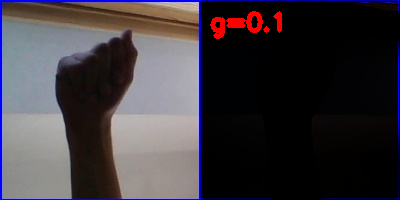

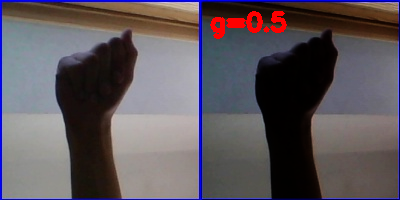

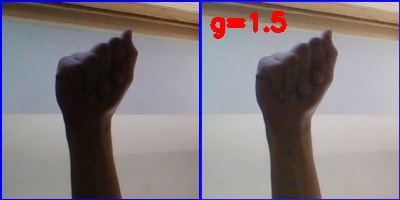

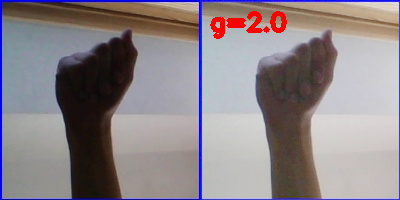

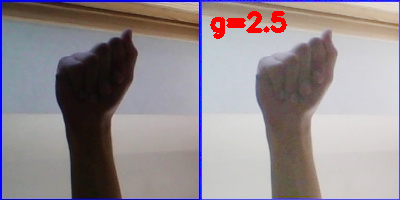

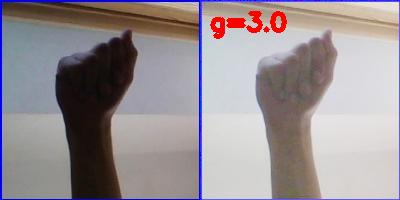

In [ ]:
#from google.colab.patches import cv2_imshow
img= cv2.imread('/content/asl_alphabet_train/asl_alphabet_train/A/A2.jpg') #reading a sample image to check against different gamma values
for gamma in np.arange(0.0, 3.5, 0.5):
	# ignore when gamma is 1 (there will be no change to the image)
	if gamma == 1:
		continue
	# apply gamma correction and show the images
	gamma = gamma if gamma > 0 else 0.1
	adjusted = adjust_gamma(img, gamma=gamma)
	cv2.putText(adjusted, "g={}".format(gamma), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
	cv2_imshow(np.hstack([img, adjusted]))
	#cv2.waitKey(0)

Gamma value of 2.0 seems to work fine. The fingers are clearly visible in the image now

Since the application of gamma decreses the contrast of the images, this can be adjusted by increasing the beta value (contrast) to make the image even more clear 

Applying transformations for contrast and brightness

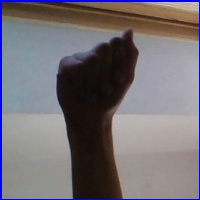

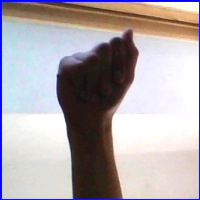

-1

In [ ]:

image = cv2.imread('/content/asl_alphabet_train/asl_alphabet_train/A/A1.jpg')

alpha = 1.5 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

cv2_imshow(image)
cv2_imshow(adjusted)
cv2.waitKey()

Now that we know the optimal valules of alppha,beta and gamma, we can apply these transformations to all the images

In [ ]:
alphabets = ['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','del']
alpha = 1
beta = 1
gamma = 2
#count=0
for alphabet in alphabets:

  for i in range(1,3000):
    img=cv2.imread('/content/asl_alphabet_train/asl_alphabet_train/'+alphabet+'/'+alphabet+str(i)+'.jpg')
    
    gamma_adjusted = adjust_gamma(img, gamma)
    cont_adjusted = cv2.convertScaleAbs(gamma_adjusted, alpha=alpha, beta=beta)
    #cv2_imshow(np.hstack([img, adjusted]))
    cv2.imwrite('/content/asl_alphabet_train/asl_alphabet_train/'+alphabet+'/'+alphabet+str(i)+'.jpg', cont_adjusted)

## 4. Implementing MediaPipe Framework

Applying MediaPipe framework to the processed images to get the key landmark points and landmark connection drawings.

1. This piece of code loops through all the alphabets and all the images under those labels. 
2. Each of the image is processed for hand and landmark detection
3. There are two kinds outputs which are saved from this code. Landmark drawings and Landmark co-ordinates in form of NumPy array

In [ ]:
alphabets = ['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','del']

count=0
not_detected=0
for alphabet in alphabets:

  for i in range(1,3000):
  
    IMAGE_FILES = ['/content/asl_alphabet_train/asl_alphabet_train/'+alphabet+'/'+alphabet+str(i)+'.jpg']
    NP_FILES = '/content/asl_alphabet_train/asl_alphabet_train/numpyfiles/'+alphabet+'/'+alphabet+str(i)
    with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
      for idx, file in enumerate(IMAGE_FILES):
    # Read an image, flip it around y-axis for correct handedness output (see
    # above).
        image = cv2.flip(cv2.imread(file), 1)
    # Convert the BGR image to RGB before processing.
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #print('Handedness:', results.multi_handedness)
#if not results.multi_hand_landmarks:
#  continue
        image_height, image_width, _ = image.shape
        annotated_image = image.copy()
        try:
          for hand_landmarks in results.multi_hand_landmarks:
            #print('hand_landmarks:', hand_landmarks)
            #print(
                #f'Index finger tip coordinates: (',
                #f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
                #f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
            #)
            mp_drawing.draw_landmarks(
                annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
          cv2.imwrite(
                  '/content/asl_alphabet_train/asl_alphabet_train/landmark/'+alphabet +str(i)+'.png', cv2.flip(annotated_image, 1))
          all_landmarks=[]
          for res in results.multi_hand_landmarks[0].landmark:
            test=np.array([res.x,res.y,res.z])
            all_landmarks.append(test)
            #print(all_landmarks)
          #print('saving np.....')
          np.save(NP_FILES, all_landmarks)
          count=count+1
        except:
            not_detected=not_detected+1
            #print('No Landmarks detected')

In [ ]:
print('Number of images processed : ',count)
print('Number of undetected images : ',not_detected)

Number of images processed :  70729
Number of undetected images :  13243


In [ ]:
#Missing Percentage
13243/(13243+70729)*100  # 15%

15.770733101510025

## 5. Data Preparation for ML model building

Creating Label map for each alphabets

In [ ]:
#Creating Label map for each alphabets

alphabets = np.array(['A', 'B', 'C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','del'])
label_map = {label:num for num, label in enumerate(alphabets)}

Importing the landmarks and concatenating them with respect to the label

In [ ]:
#NP_FILES = '/content/drive/MyDrive/asl_date/asl_alphabet_train/numpyfiles/'+alphabet'
sequences, labels = [], []
for alphabet in alphabets:
    NP_FILES = '/content/asl_alphabet_train/asl_alphabet_train/numpyfiles/'
    for sequence in np.array(os.listdir(os.path.join(NP_FILES, alphabet))):
        res = np.load(os.path.join(NP_FILES, alphabet, str(sequence)))
        sequences.append(res)
        labels.append(label_map[alphabet])

In [ ]:
np.array(sequences).shape #checking the shape of the resulted array 

(70729, 21, 3)

Reshaping the array to concatenate the values of X,Y,Z co-ordinates 

In [ ]:
X=np.array(sequences).reshape(70729,63)
y=np.array(labels).shape

Converting the labels to one-hot encoding pattern 

In [ ]:
y=to_categorical(np.array(labels))
y.shape

(70729, 28)

Splitting the Train-Test data

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.05)

## 6. Multi-lable classification model

Using Random forest classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier


RF_model = RandomForestClassifier(max_depth=20, random_state=0).fit(X_train, y_train)
y_pred = RF_model.predict(X_test)
y_pred_prob = RF_model.predict_proba(X_test)


In [ ]:
cm = multilabel_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
def sensitivity(y_true,y_pred):
        cm=confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        Sensitivity = TP/(TP+FN)    
        return np.mean(Sensitivity)

def specificity(y_true,y_pred):
    cm=confusion_matrix(y_true, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    Specificity = TN/(TN+FP)    
    return np.mean(Specificity)

Checking other evaluation criteria 

In [ ]:
print('Specificity : ', specificity(y_pred.argmax(axis=1),y_test.argmax(axis=1)))
print('Sensitivity : ',sensitivity(y_pred.argmax(axis=1),y_test.argmax(axis=1)))
print('Accuracy :    ',accuracy_score(y_test, y_pred))

Specificity :  0.9981123516144411
Sensitivity :  0.975164427087517
Accuracy :     0.9459994345490529


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 20).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
 
# creating a confusion matrix
cm_dt = multilabel_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
print('Specificity : ', specificity(dtree_predictions.argmax(axis=1),y_test.argmax(axis=1)))
print('Sensitivity : ',sensitivity(dtree_predictions.argmax(axis=1),y_test.argmax(axis=1)))
print('Accuracy :    ',accuracy_score(y_test, dtree_predictions))

Specificity :  0.9959999823100752
Sensitivity :  0.9048844135794368
Accuracy :     0.8886061634153237


In [ ]:
import xgboost as xgb
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# create XGBoost instance with default hyper-parameters
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')

# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# fit the model
multilabel_model.fit(X_train, y_train)
xg_pred=multilabel_model.predict(X_test)

# evaluate on test data
#print('Accuracy : '(accuracy_score(y_test, multilabel_model.predict(X_test))*100))

In [ ]:
print('Specificity : ', specificity(xg_pred.argmax(axis=1),y_test.argmax(axis=1)))
print('Sensitivity : ',sensitivity(xg_pred.argmax(axis=1),y_test.argmax(axis=1)))
print('Accuracy :    ',accuracy_score(y_test, multilabel_model.predict(X_test)))

Specificity :  0.9948693544701055
Sensitivity :  0.9553579464664629
Accuracy :     0.8546791065875036


## 7. Results and Discussion

The best results are produced by Random Forest model with the follwing evaluation parameters
1. Specificity :  0.99
2. Sensitivity :  0.98
3. Accuracy :     0.95